In [1]:
%matplotlib notebook
import math
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt

# Data

In [2]:
GW170104 = 'H-H1_GWOSC_16KHZ_R1-1167559921-32.txt'
GW170608 = 'H-H1_GWOSC_16KHZ_R1-1180922479-32.txt'
GW170814 = 'H-H1_GWOSC_16KHZ_R1-1186741846-32.txt'
GW170817 = 'H-H1_GWOSC_16KHZ_R1-1187008867-32.txt'
GW190425 = 'L-L1_GWOSC_16KHZ_R1-1240215487-32.txt' #not sure about this one, there was no H1 file for this, only L1 and V1
GW190412 = 'H-H1_GWOSC_16KHZ_R2-1239082247-32.txt'
GW150914 = 'H-H1_GWOSC_16KHZ_R1-1126259447-32.txt'
GW190521 = 'H-H1_GWOSC_16KHZ_R2-1242442952-32.txt'

GW170104_tbl = Table.read(GW170104, format='ascii')
GW170608_tbl = Table.read(GW170608, format='ascii')
GW170814_tbl = Table.read(GW170814, format='ascii')
GW170817_tbl = Table.read(GW170817, format='ascii')
GW190425_tbl = Table.read(GW190425, format='ascii') #this is the L1 file
GW190412_tbl = Table.read(GW190412, format='ascii')
GW150914_tbl = Table.read(GW150914, format='ascii')
GW190521_tbl = Table.read(GW190521, format='ascii')

In [3]:
GW170104_strain = GW170104_tbl['-2.9550085672987675e-19']
GW170608_strain = GW170608_tbl['1.6421373582598675e-20']
GW170814_strain = GW170814_tbl['-7.6681619209110251e-19']
GW170817_strain = GW170817_tbl['5.8751133791669278e-19']
GW190425_strain = GW190425_tbl['-5.5244482372502713e-20'] #this is the L1 file
GW150914_strain = GW150914_tbl['6.0951345581611108e-21']
GW190521_strain = GW190521_tbl['-6.9973189495553901e-21']

# Functions

In [4]:
G = 6.67e-11 # N kg^-2 m^2
c = 3e8 # m/s

def distance_to_GW(t, M_sol, h_max, i):
    '''This function will give the non-localized distance (in Mpc) to the gravitational wave 
    when inputting time in seconds, combined mass (or chirp mass) in solar masses, and the maximum strain in Hz.'''
    
    M = M_sol * (2 * 10**30) # gives mass in kg
    
    term1 = (5/256)**(3/8)
    term2 = ((c**3) / (G * M))**(5/8)
    term3 = (1 / (t**(3/8)))
    term4 = (t**(5/8))
    
    orbital_freq = term1 * term2 * term3
    orbital_phase = np.round(0.36571582 * term2 * term4) #round terms to third sig fig, round the constant to third sig fig
    
    distance = (2*c / h_max) * (G*M / (c**3))**(5/3) * orbital_freq**(2/3) *(1 + np.cos(i)**2)* abs(np.cos(2 * orbital_phase)) # this is distance in meters
    
    #print(orbital_freq) # printed this just to check the value of it
    #print(orbital_phase) # printed this just to check the value of it
    #print(orbital_freq)
    #print(orbital_phase)
    return distance / (9.223 * 10**18)#i returns distance in Mpc. 2.25 update: change [distance / (9.223 * 10**18), i]
    # distance only, for debugging best_i_arr. If anyone need to use best_angle again, please change the return statement to the original one

distance_to_GW(32, 63.1, 7.912043421880075e-19, 1.22)

440.7248001991815

In [5]:
def best_i(actual_dis, f): # a helper function for best_i_arr, does similar things as best_angle
    angle_lst = np.arange(0, math.pi , 0.00001)
    best_dif = float('inf')
    best_i = 0
    for i in range(len(angle_lst)):
        d = f(angle_lst[i])
        if abs(d - actual_dis) < best_dif:
            best_i = angle_lst[i]
            best_dif = abs(d - actual_dis)

    return best_i

def best_i_arr(actual_arr, t_arr, chirp_mass_arr, h_max_arr): # give it arrays of: actual distance, time, h_max, and chirp_mass
    i_array = []
    f_arr = []  #a helper function array that returns gw_distance but only need to input angle i
    for n in range(len(t_arr)):
        f_arr.append(lambda x: distance_to_GW(t_arr[n],chirp_mass_arr[n], h_max_arr[n], x))

    for m in range(len(f_arr)):
        i_array.append(best_i(actual_arr[m], f_arr[m]))
       # print(best_i(actual_arr[m], f_arr[m]))

    return i_array

def gw_dis_array(t_arr, chirp_mass_arr, h_max_arr, i_arr):
    ret = []
    for i in range(len(t_arr)):
        ret.append(distance_to_GW(t_arr[i], chirp_mass_arr[i], h_max_arr[i], i_arr[i]))
    return ret

In [6]:
best_i(440, lambda i: distance_to_GW(32, 63.1, 7.912043421880075e-19,i)), best_i_arr([440], [32], [63.1], [7.912043421880075e-19]),gw_dis_array([32], [63.1], [7.912043421880075e-19], [math.pi/2])

(1.22286, [1.22286], [394.17565185908205])

In [7]:
def max_strain(strain_arr):
    max_str = [] 
    for i in np.arange(len(strain_arr)):
        max_str.append(max(abs(strain_arr[i])))
    return max_str

In [8]:
def best_distance(lum_dist, times, masses, max_str):
    
    #logistics
    #assert len(lum_dist) == len(times) == len(masses) == len(max_str) == 10
    lum_dist = np.array(lum_dist)
    masses = np.array(masses)
    times = np.array(times)
    max_str = np.array(max_str)
    
    #calc
    distance_and_angles = []
    for i in np.arange(len(times)):
        d = [] #shape = (2, 90)
        for angle in np.arange(0, np.pi/2, 0.001):
            distance = distance_to_GW(times[i], masses[i], max_str[i], angle)
            dist_for_angle = np.array([distance, angle])
            #print(dist_for_angle)
            d.append(dist_for_angle)
        ith_dist_angle = best_result(d, lum_dist[i])
        distance_and_angles.append(ith_dist_angle)
        
    return distance_and_angles


def best_result(distances, lum_dist):
    '''Computes the best angle by minimizing the distances calculated to the actual distance'''
    best_difference = float('inf')
    best_angle = 0
    
    for i in distances: 
        
        best_d = abs(i[0] - lum_dist) #i[0] = estimated distance
        #print(i[0])
        if best_d < best_difference:
            best_difference = best_d
            best_arr = i
            #print(i)
    return best_arr

# Testing Grounds

In [9]:
# GW170608
# GW170814
# GW170817
# GW190425
# GW150914
# GW190521

luminosity_dist = [320, 600,40, 159, 440, 5300] # Mpc
chirp_mass = [7.9,24.1, 1.186, 1.487,28.6, 64.] # Solar Masses
final_mass = [17.8,53.2, 2.8, 3.4,63.1,150.] # Solar Masses
tim = [32, 32, 32, 32, 32, 32] # seconds

str_arr = [np.array(GW170608_strain), np.array(GW170814_strain), np.array(GW170817_strain),
      np.array(GW190425_strain), np.array(GW150914_strain), np.array(GW190521_strain)]

strain_max = max_strain(str_arr)
strain_max

[1.2159378610812219e-18,
 1.0322913226585846e-18,
 1.2427272842601703e-18,
 1.1516671707217659e-18,
 7.912043421880075e-19,
 3.2880256024887114e-19]

In [10]:
best_distance(np.array(luminosity_dist), np.array(tim), np.array(final_mass), np.array(strain_max))

[array([122.22691292,   0.        ]),
 array([176.73374883,   0.        ]),
 array([4.99279652, 0.        ]),
 array([17.73467553,  0.        ]),
 array([439.96427018,   1.223     ]),
 array([5.30171884e+03, 8.90000000e-01])]

In [11]:
best_i(320, lambda i: distance_to_GW(32, 17.8, 1.2159378610812219e-18,i)*3)

0.52891

In [12]:
# Test
n = 0 

actual = luminosity_dist[n]
tst = distance_to_GW(32, 17.8,1.2159378610812219e-18 ,0.528)*3
actual, tst

(320, 320.1450646766827)

In [13]:
abs(actual-tst)/actual * 100

0.045332711463341724

In [14]:
n = 2

G = 6.67e-11 # N kg^-2 m^2
c = 3e8 # m/s
M = final_mass[n] * 2e30 # kg 
t = tim[n]
h_max = strain_max[n]

i = np.arange(0, np.pi/2, 0.001) #rad

term1 = (5/256)**(3/8)
term2 = ((c**3) / (G * M))**(5/8)
term3 = (1 / (t**(3/8)))
term4 = (t**(5/8))
    
orbital_freq = term1 * term2 * term3
orbital_phase = np.round(0.36571582 * term2 * term4) #round terms to third sig fig, round the constant to third sig fig
    
distance = ((2*c / h_max) * (G*M / (c**3))**(5/3) * orbital_freq**(2/3) *(1 + np.cos(i)**2)* abs(np.cos(2 * orbital_phase)))/9.223e18 # this is distance in meters

distances = []

for x in np.arange(len(i)):
    distances.append(((2*c / h_max) * (G*M / (c**3))**(5/3) * orbital_freq**(2/3) *(1 + np.cos(i[x])**2)* abs(np.cos(2 * orbital_phase)))/9.223e18)

y = (np.zeros(len(i))+1) * luminosity_dist[n]

distances = np.array(distances)

<IPython.core.display.Javascript object>


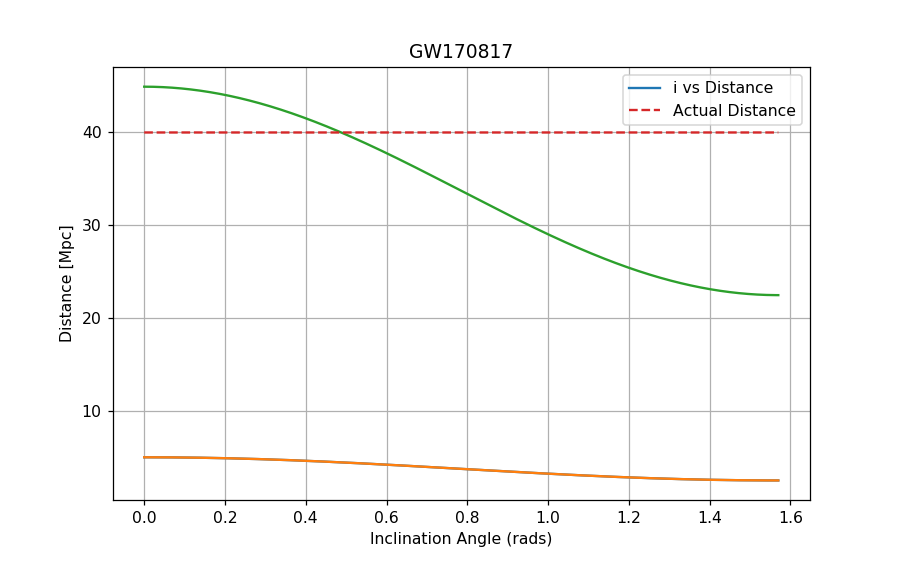

In [27]:
plt.figure(figsize=(8,5))
plt.plot(i, distances, label = 'i vs Distance')
plt.plot(i, distances*1)
plt.plot(i, distances*9)
plt.plot(i,y, label = 'Actual Distance', linestyle = '--')
plt.xlabel('Inclination Angle (rads)')
plt.ylabel('Distance [Mpc]')
plt.title('GW170817')
plt.legend()
plt.grid()

In [ ]:
distances * 3

## What I found...

###  *  The Problem: the range of i is out of bounds for the distance values we calculate.  

###  * The Solution:  

* There seems to be some relation between D and i s.t. $D \propto i$.

* Since $D \propto i$, we should be able to **multiply the D value by some scalar between 1 and 10 until the distance values are close enough to d_actual.**

* Once d_actual is known, you can determine the correct inclination angle and the correct scalar value to multiply to D to get the correct distance

* The main question regarding this fitting method is **Why is there a scalar multiple on D and what does it mean**

### Psuedo Code for distance_fix()

* If best_i == 0 --> find best_i*n 

* If best_i*n != 0 and distance is close, save value 


## Corrected Function

In [20]:
# Find best_i 

for n in np.arange(5):
    inc = best_i(320, lambda i: distance_to_GW(32, 17.8, 1.2159378610812219e-18,i)*n)
    if inc == 0: 
        inc = best_i(320, lambda i: distance_to_GW(32, 17.8, 1.2159378610812219e-18,i)*n)
    print(inc)

0.0
0.0
0.0
0.52891
2.16026


In [21]:
n = 4 
best_ang = []

inc = best_i(luminosity_dist[x], lambda i: distance_to_GW(32, 17.8, 1.2159378610812219e-18,i)) # OG inc

while n < 5: 
    if inc == 0:   # check current inc
        n+=1
        inc = best_i(320, lambda i: distance_to_GW(32, 17.8, 1.2159378610812219e-18,i)*n) # reclac inc if wrong
        print(inc,n)
    elif inc_n != 0:
        d = distance_to_GW(32, 17.8,1.2159378610812219e-18 ,inc)*n
        print('D = ' + str(d) + 'Mpc')
        print(inc, n)    # save inc and n 
        break

IndexError: list index out of range

In [ ]:
#x = 5

n = 1 
best_ang = []



for x in np.arange(len(tim)):
    n = 1
    inc = best_i(luminosity_dist[x], lambda i: distance_to_GW(tim[x], final_mass[x], strain_max[x],i)) # OG inc
    while n < 11: 
        if inc == 0:   # check current inc
            n+=1
            inc = best_i(luminosity_dist[x], lambda i: distance_to_GW(tim[x], final_mass[x], strain_max[x],i)*n) # reclac inc if wrong
            print(inc,n)
        elif inc != 0:
            print(inc, n)    # save inc and n 
            d = distance_to_GW(tim[x], final_mass[x], strain_max[x] ,inc)*n # recalc dist
            print('D = ' + str(d) + ' Mpc')
            print('D_actual = ' + str(luminosity_dist[x]))
            break
    print('')
    print(x)

In [22]:
def fix_inc(lum_dist, times, mass, max_strain):
    
    d_new = []
    
    for x in np.arange(len(tim)):
        n = 1
        inc = best_i(lum_dist[x], lambda i: distance_to_GW(times[x], mass[x], max_strain[x],i)) # OG inc
        
        #print('iteration: ' + str(x))
        
        while n < 11: 
            if inc == 0:   # check current inc
                n+=1
                inc = best_i(lum_dist[x], lambda i: distance_to_GW(times[x], mass[x], max_strain[x],i)*n) # reclac inc if wrong
                
            elif inc != 0: 
                d = distance_to_GW(times[x], mass[x], max_strain[x],inc)*n # recalc dist
                
                print('-----')
                print('i_new = ' + str(inc) + ' | ' + 'n = ' + str(n))
                print('D_new = ' + str(np.round(d,5)) + ' Mpc')
                print('D_actual = ' + str(lum_dist[x]) + ' Mpc')
                print('-----')
                print('')
                d_new.append([d,inc])
                
                break    
    return d_new

In [23]:
test = fix_inc(luminosity_dist, tim, final_mass, strain_max)

-----
i_new = 0.52891 | n = 3
D_new = 319.99977 Mpc
D_actual = 320 Mpc
-----

-----
i_new = 0.5824 | n = 4
D_new = 599.99946 Mpc
D_actual = 600 Mpc
-----

-----
i_new = 2.6538000000000004 | n = 9
D_new = 39.99998 Mpc
D_actual = 40 Mpc
-----

-----
i_new = 0.08769 | n = 9
D_new = 158.99998 Mpc
D_actual = 159 Mpc
-----

-----
i_new = 1.22286 | n = 1
D_new = 439.99964 Mpc
D_actual = 440 Mpc
-----

-----
i_new = 2.2511300000000003 | n = 1
D_new = 5300.00045 Mpc
D_actual = 5300 Mpc
-----



In [ ]:
# GW170608
# GW170814
# GW170817
# GW190425
# GW150914
# GW190521

In [24]:
print('Prelim Results')
print('--------------')
print('')

print('\033[4mGW170608\033[0m:')
print('D_actual = ' + str(luminosity_dist[0]) + ' Mpc')
print('D_estimate = ' + str(test[0][0]))
print('Inclination Angle: i = ' + str(test[0][1]) + 'rads')
print('Error: ' + str(np.round(abs(test[0][0]-luminosity_dist[0])/luminosity_dist[0]*100,5)) + '%')
print('')

print('\033[4mGW170814\033[0m:')
print('D_actual = ' + str(luminosity_dist[1]) + ' Mpc')
print('D_estimate = ' + str(test[1][0]))
print('Inclination Angle: i = ' + str(test[1][1]) + 'rads')
print('Error: ' + str(np.round(abs(test[1][0]-luminosity_dist[1])/luminosity_dist[1]*100,5)) + '%')
print('')

print('\033[4mGW170817\033[0m:')
print('D_actual = ' + str(luminosity_dist[2]) + ' Mpc')
print('D_estimate = ' + str(test[2][0]))
print('Inclination Angle: i = ' + str(test[2][1]) + 'rads')
print('Error: ' + str(np.round(abs(test[2][0]-luminosity_dist[2])/luminosity_dist[2]*100,5)) + '%')
print('')

print('\033[4mGW190425\033[0m:')
print('D_actual = ' + str(luminosity_dist[3]) + ' Mpc')
print('D_estimate = ' + str(test[3][0]))
print('Inclination Angle: i = ' + str(test[3][1]) + 'rads')
print('Error: ' + str(np.round(abs(test[3][0]-luminosity_dist[3])/luminosity_dist[3]*100,5)) + '%')
print('')

print('\033[4mGW150914\033[0m:')
print('D_actual = ' + str(luminosity_dist[4]) + ' Mpc')
print('D_estimate = ' + str(test[4][0]))
print('Inclination Angle: i = ' + str(test[4][1]) + 'rads')
print('Error: ' + str(np.round(abs(test[4][0]-luminosity_dist[4])/luminosity_dist[4]*100,5)) + '%')
print('')

print('\033[4mGW190521\033[0m:')
print('D_actual = ' + str(luminosity_dist[5]) + ' Mpc')
print('D_estimate = ' + str(test[5][0]))
print('Inclination Angle: i = ' + str(test[5][1]) + 'rads')
print('Error: ' + str(np.round(abs(test[5][0]-luminosity_dist[5])/luminosity_dist[5]*100,5)) + '%')
print('')

Prelim Results
--------------

GW170608:
D_actual = 320 Mpc
D_estimate = 319.99977386324167
Inclination Angle: i = 0.52891rads
Error: 7e-05%

GW170814:
D_actual = 600 Mpc
D_estimate = 599.9994642682238
Inclination Angle: i = 0.5824rads
Error: 9e-05%

GW170817:
D_actual = 40 Mpc
D_estimate = 39.99997836665554
Inclination Angle: i = 2.6538000000000004rads
Error: 5e-05%

GW190425:
D_actual = 159 Mpc
D_estimate = 158.99997966310465
Inclination Angle: i = 0.08769rads
Error: 1e-05%

GW150914:
D_actual = 440 Mpc
D_estimate = 439.9996406355539
Inclination Angle: i = 1.22286rads
Error: 8e-05%

GW190521:
D_actual = 5300 Mpc
D_estimate = 5300.0004547391845
Inclination Angle: i = 2.2511300000000003rads
Error: 1e-05%



# Estimating v using Z from LIGO 

## $$v = cZ$$

In [29]:
z = np.array([0.07,0.12,0.01, 0.03, 0.09, 0.82])
v = z  * 3e5 # km/s
test[0][0]

dist = []

for i in np.arange(len(tim)):
    dist.append(test[i][0])
    

<IPython.core.display.Javascript object>


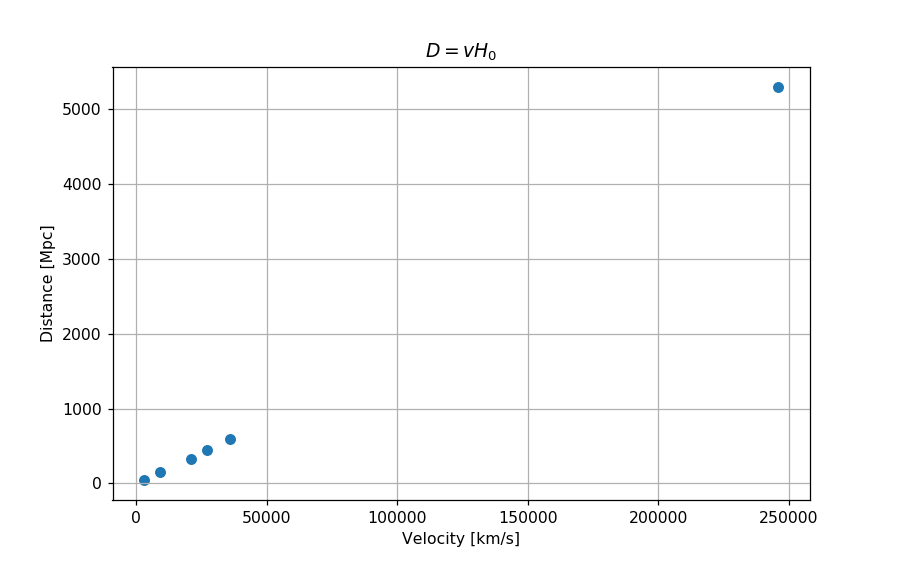

In [30]:
plt.figure(figsize=(8,5))
plt.scatter(v, dist)
plt.xlabel('Velocity [km/s]')
plt.ylabel('Distance [Mpc]')
plt.title('$D=v H_{0}$')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


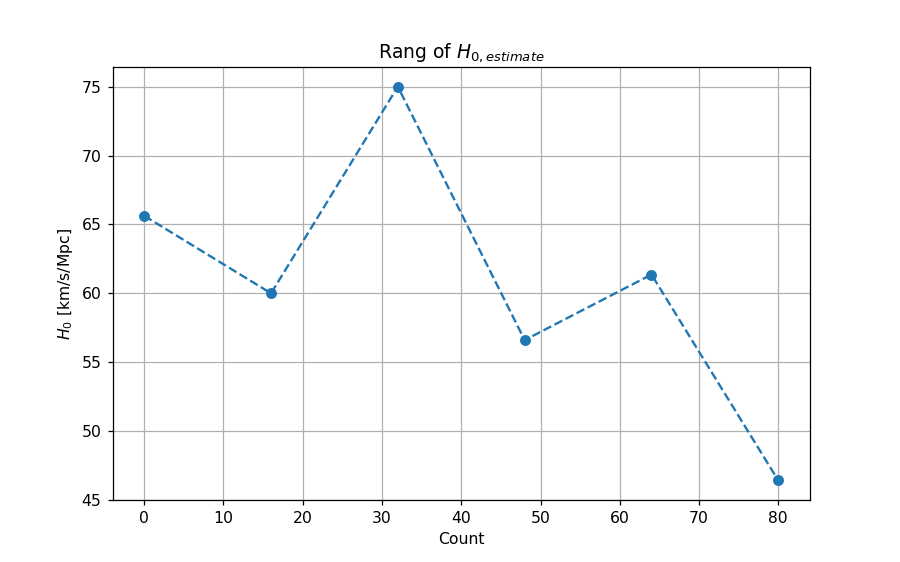

In [31]:
plt.figure(figsize=(8,5))
plt.plot(np.linspace(0,80,6),v/dist, 'o--')
plt.title('Rang of $H_{0,estimate}$')
plt.xlabel('Count')
plt.ylabel('$H_{0}$ [km/s/Mpc]')
plt.grid()
plt.show()

$$D = \frac{2c}{h_+} \left( \frac{G \mathcal{M}}{c^3}\right)^{5/3} \Omega^{\frac{2}{3}}(t) \left(1+cos^2i\right) cos2\Phi(t)$$
